# Convolutions and deep neural networks

After we introduced the basics of neural networks via fully connected neural networks we will take a look at a new type of neural network, called *Convolutional neural networks* (CNN).
CNNs helped the fame of neural networks a lot as they outperformed existing algorithms on object detection or face recognition *"over night"* - this was a reason more and more people took a look at neural networks and also introduced the notion of *deep learning*.

Before we will take a look at how to build and learn such a CNN we will take a look at how they differ from the formely discussed fully connected neural networks.
For our MNIST example we converted the $28 \times 28$ pixel image into a $784$ dimensional vector as the input of such a neural network needs to be a vector.
But while flattening the 2 dimennsional image into a 1 line of numbers we loose spatial structure and connectedness which is important when working on visual data.
And right at the beginning of the neural network is where a CNN differs: Instead of just processing vectors a CNN can process tensors (tensor = *"a multidimensional array"*) and we can therefore preserve the spatial structure of our data.

Before we take a look at how a CNN works we will take a look at convolutions first.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from scipy import misc
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (15, 5)

np.random.seed(42)

## Convolutions

A convolution is simply a multiplication of a matrix $A$ with a *filter* which is also a matrix $F$.
Often the size of the filter is much smaller than our input image, therefore we use a *sliding window* approach to slide our filter over the whole image.
Think of it like using a small magnifier glass to scan over the whole picture, but instead of a maginfier glass we use a mathematical operation (a matrix is actually just that) on the section of the image.

$$
AF
$$

We can take a look at how different filters modify our input image.

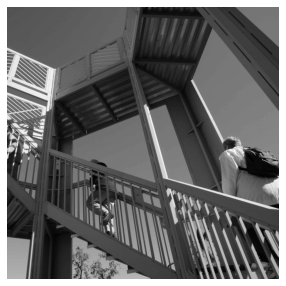

In [ ]:
# get an image which is availabile in scipy
ascent = misc.ascent()
plt.imshow(ascent, cmap='gray')
plt.axis('off');

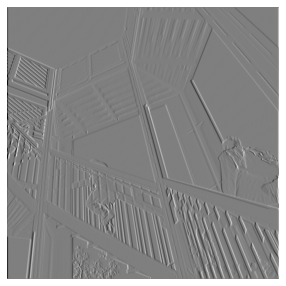

In [ ]:
filter = np.array([
	[-3, 0, 3],
	[-10, 0, +10],
	[-3, 0, +3],
])
filtered_image = signal.convolve2d(ascent, filter)
plt.imshow(filtered_image, cmap='gray')
plt.axis('off');

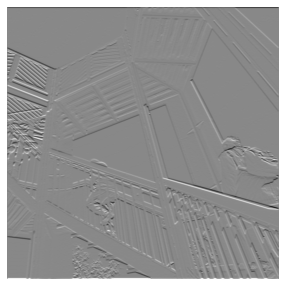

In [ ]:
filter = np.array([
	[-6, -6, -6],
	[0, 0, 0],
	[6, 6, 6],
])
filtered_image = signal.convolve2d(ascent, filter)
plt.imshow(filtered_image, cmap='gray')
plt.axis('off');

We can see that with different kind of filters we can obtain different view on a picture.
Here we only took a look at filters who perform something like an edge detection but there are also possibillities to also create blurring filters.
For some examples see [Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing)) in image processing.

One thing we have not talked about yet is the sliding of our filter across the image.
What happens on the corners (called *padding*)?
And also what happens if we change the size of the steps (called *stride*) we use to slide the filter over our image?
Modifying these parameters allows us modify the output size of our convolution and is called [convolutional arithmetic](https://github.com/vdumoulin/conv_arithmetic).
For example using a stride size of 1 but not exceeding the boundaries (*padding* ) of our image (blue) will result in a smaller output (green).

![Blue maps are inputs, and cyan maps are outputs](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

Source: [https://github.com/vdumoulin/conv_arithmetic](https://github.com/vdumoulin/conv_arithmetic)

## Convolutional neural networks

Where in a fully connected neural networks the weights of the neurons gets adjusted during training we can use this method to *train* covolution filters that extract relevant information out of the image.

```{todo}
    explain padding = same
```

Instead of just using one filter for the whole image we can use multiple filters which add a new dimension to our data.
If our image data is $28 \times 28$ and passed into a 32 *filters* with a $3 \times 3$ *kernel* with *stride=2* and *padding=same* we get

$$
\underbrace{n}_{\text{\# images}} \times \underbrace{28\times28}_{\text{image size}} \overbrace{\Rightarrow}^{\text{convolution with 32 filters}} \underbrace{n}_{\text{\# images}} \times \underbrace{14 \times 14}_{\text{image size / stride size}} \times \underbrace{32}_{\text{\# filters}}
$$

In each layer of our neural network we tend to reduce the dimensions of our original image while increasing the dimensions of our filters of the convolutions.
This behaviour is called *going deep* and accounts for the term *deep learning*.

A real world example for this technique is used in e.g. [ResNet](https://arxiv.org/abs/1512.03385v1) which was used as a reference network for different problems in computer vision (although this paper became famous because it introduced residual connections which allowed to train such deep networks).
Each block in the graphic is a convolution, reaching at the end a $3 \times 3 \times 512$ dimensional state which is then flattened (as before with our image in the fully connected network).
The idea is that the convolutional layers extract information out of the image and the last fully connected layer(s) are using the extracted information out of the convolutional layers to extract the image.

![Building blocks of resnet](resnet.png)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# add dim b/c of convolution
# scale data from [0,255] to [0,1] for better training
x_train_cnn = x_train[:, :, :, np.newaxis] / 255.0
x_test_cnn = x_test[:, :, :, np.newaxis] / 255.0

We will now define our neural network with convolutional and max pooling layers.
Max pooling layers slide across the image like a convolutional layer but instead of trying to train filters they will only output the maximum value within its window, e.g.

$$
\text{max pool} \left( \begin{bmatrix}
0 & 2\\
1 & 0
\end{bmatrix} \right)
= 2
$$

This layer is often used to reduce the dimensions of our input, narrowing it for the input of the next layer.

It is best to understand the output shape of all layers on the summary below.

In [ ]:
cnn_model = keras.models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    # max pooling is a special kind of layer which only takes the
    # max values in its pool size which is slided over the tensors
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64),
    layers.Dropout(0.5),
    layers.Dense(10),
], name="cnn")

cnn_model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                200768  

2021-12-05 17:19:04.018118: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As with our fully connected layer we will need to determine how the weights (so the values of our filters in the convolution) should be trained/adjusted according to our traning data.
We will use the same settings as with the fully connected network.

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy'
)

We will train the network.

In [ ]:
cnn_model.fit(x_train_cnn, y_train, batch_size=256, epochs=10)

Epoch 1/10
235/235 [==============================] - 13s 53ms/step - loss: 0.3311 - accuracy: 0.8998
Epoch 2/10
235/235 [==============================] - 13s 55ms/step - loss: 0.0932 - accuracy: 0.9724
Epoch 3/10
235/235 [==============================] - 14s 58ms/step - loss: 0.0696 - accuracy: 0.9788
Epoch 4/10
235/235 [==============================] - 14s 61ms/step - loss: 0.0557 - accuracy: 0.9830
Epoch 5/10
235/235 [==============================] - 15s 63ms/step - loss: 0.0457 - accuracy: 0.9856
Epoch 6/10
235/235 [==============================] - 15s 64ms/step - loss: 0.0422 - accuracy: 0.9869
Epoch 7/10
235/235 [==============================] - 15s 65ms/step - loss: 0.0365 - accuracy: 0.9888
Epoch 8/10
235/235 [==============================] - 15s 62ms/step - loss: 0.0337 - accuracy: 0.9901
Epoch 9/10
235/235 [==============================] - 15s 64ms/step - loss: 0.0294 - accuracy: 0.9909
Epoch 10/10
235/235 [==============================] - 15s 63ms/step - loss: 0.026

And get improved results, yet a neural network only performs good if it also works good on data it has not seen before.
Therefore we will evaluate the neural network on the test set.

In [ ]:
cnn_model.evaluate(x_test_cnn, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0271 - accuracy: 0.9908


[0.02713589183986187, 0.9908000230789185]

We will now take a look at the wrong predictions of the network to see where it struggles.

In [ ]:
preds_cnn = cnn_model.predict(x_test_cnn[:, :, :, np.newaxis])
preds_cnn_one_hot = np.argmax(preds_cnn, axis=1)
false_indices_cnn = np.argwhere(preds_cnn_one_hot != y_test)

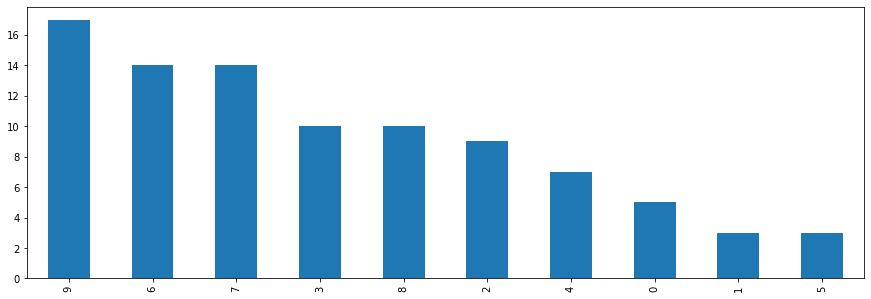

In [ ]:
pd.Series(y_test[false_indices_cnn].flatten()).value_counts().plot.bar();

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_test, preds_cnn_one_hot)
confusion_matrix

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 975,    0,    0,    1,    0,    1,    2,    0,    1,    0],
       [   0, 1132,    1,    1,    0,    0,    0,    0,    1,    0],
       [   0,    1, 1023,    0,    1,    0,    0,    6,    1,    0],
       [   0,    0,    0, 1000,    0,    8,    0,    1,    1,    0],
       [   0,    0,    0,    0,  975,    0,    0,    0,    0,    7],
       [   0,    0,    0,    2,    0,  889,    1,    0,    0,    0],
       [   2,    2,    0,    1,    3,    5,  944,    0,    1,    0],
       [   0,    1,    7,    1,    0,    0,    0, 1014,    1,    4],
       [   1,    0,    2,    0,    0,    2,    1,    1,  964,    3],
       [   0,    1,    1,    0,    3,    7,    0,    4,    1,  992]],
      dtype=int32)>

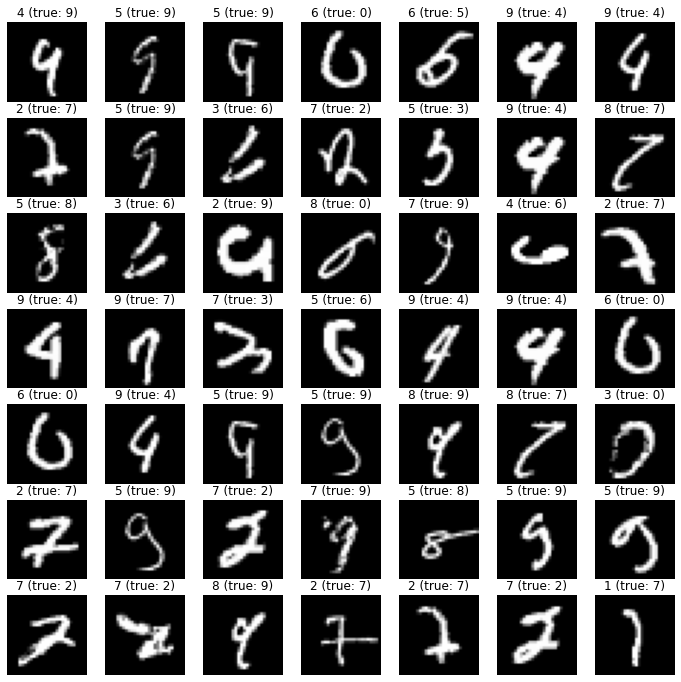

In [ ]:
n_rows=7
n_cols=7
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
for i, idx in enumerate(np.random.choice(false_indices_cnn.flatten(), n_rows*n_cols)):
    ax = axs[i%n_rows][i//n_rows]
    ax.imshow(x_test[idx], cmap='gray')
    ax.set_title(f'{preds_cnn_one_hot[idx]} (true: {y_test[idx]})')
    ax.axis('off')